# Logic

We need (what we think are) meaningful values for each measure.

For example, for each of the health kit tasks (e.g. **Stroop**) find out what people feel are the most meaningful ways to summarize the input into an interpretable output value.

With these values we then create features that compare them to themselves. For example to the day(s) before, to the measure's mean, etc.

This part needs a more rigorous understanding of predictive modeling with timeseries data.

# Start Up

## Imports

In [27]:
import numpy as np
import pandas as pd
import pickle
import datetime

import seaborn as sns

## Load Data

In [28]:
save_path = "/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/"

in_file = open(save_path + "app_data.pkl", "rb")
app_data = pickle.load(in_file)

# Table

## Add Basic Features

### Add Date Sent Out

---
**NB** | This should be the day when the survey is **sent out**...

Let's make sure that the `DueDate` refers to the correct day, since it references **UTC**, or "zero" offset (hence the `Z` at the end of the datetime string, e.g. `2021-05-01T23:55:04Z`).

In [48]:
app_data['SurveyTasks'].DueDate[0]

'2021-10-10T11:55:00Z'

---

So we need to:
- convert `DueDate` to datetime object
- convert the time to `US/Eastern` (this will account for daylight savings...nice!)
- convert to just the date (ignore time component)
- save to `ActualDueDate` column

In [49]:
app_data['SurveyTasks']['ActualDueDate'] = pd.to_datetime(app_data['SurveyTasks'].DueDate, format= '%Y-%m-%d').dt.tz_convert('US/Eastern').dt.date

### Add Day of Week

---
Now we also need to label the day of the week.

Similar process:
- convert `DueDate` to datetime object
- convert the time to `US/Eastern` (this will account for daylight savings...nice!)
- convert to day of the week
- save to `ActualWeekday`

**Important**
- 0 = Monday
- ...
- 6 = Sunday

In [50]:
# add day of week information
app_data['SurveyTasks']['DayOfWeek'] = pd.to_datetime(app_data['SurveyTasks'].DueDate, format= '%Y-%m-%d').dt.tz_convert('US/Eastern').dt.weekday

### Weekday/Weekend

In [51]:
# Saturday/Sunday take value 0
app_data['SurveyTasks']['IsWeekday'] = [1 if day<5 else 0 for day in app_data['SurveyTasks']['DayOfWeek']]

# Make categorical variable
app_data['SurveyTasks']['IsWeekday'] = app_data['SurveyTasks']['IsWeekday'].astype('category')

In [52]:
# remove duplicates (want one row for each participant/date combo)
df = app_data['SurveyTasks'].drop_duplicates(subset=['ParticipantIdentifier', 'ActualDueDate'])

In [53]:
# remove unneeded columns
df = df[['ParticipantIdentifier', 'ActualDueDate', 'DayOfWeek', 'IsWeekday']].reset_index(drop=True)
df.head()

,ParticipantIdentifier,ActualDueDate,DayOfWeek,IsWeekday
0,e7b2c780-2e2c-4181-8075-0719e0434215,2021-10-10,6,0
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16,5,0
2,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-16,5,0
3,531d7f6d-b880-4a0b-b467-80005a316f1c,2021-10-16,5,0
4,d26d4b78-7fcf-488e-b687-2d1c93c47b74,2021-10-16,5,0


### Number of tasks completed

In [54]:
# take the rows where Status is Complete
# group by participant and date
# sum (this is summing the number of survey's completed by subject and day)
df_completions = pd.DataFrame(app_data['SurveyTasks'].loc[app_data['SurveyTasks'].Status=='Complete'].groupby(['ParticipantIdentifier', 'ActualDueDate'])['Status'].count()).reset_index()
df_completions = df_completions.rename(columns={'Status': 'CompleteCount'})
df_completions.head(2)

,ParticipantIdentifier,ActualDueDate,CompleteCount
0,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-02-02,6
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-02-04,6


In [55]:
# join
df = df.merge(df_completions, how='left', on=['ParticipantIdentifier', 'ActualDueDate'])
df.head(4)

,ParticipantIdentifier,ActualDueDate,DayOfWeek,IsWeekday,CompleteCount
0,e7b2c780-2e2c-4181-8075-0719e0434215,2021-10-10,6,0,NaN
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16,5,0,NaN
2,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-16,5,0,9.0
3,531d7f6d-b880-4a0b-b467-80005a316f1c,2021-10-16,5,0,NaN


### Task Duration

---

How long from starting to finishing the task?
- Perhaps a measure of distraction?

Need to calculate the `EndDate` for the **last** task from the `StartDate` for the **first** task (for a given participant on a given day).

In [56]:
# group by participant and day
# find min(StartDate) and max(EndDate) and the time difference between
app_data['SurveyStepResults'].head(2)

,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,StepIdentifier,StartDate,EndDate,ActualDueDate,DiffDate,TaskTime
0,af755c8f-0c2f-ec11-aab2-0afb9334277d,a6755c8f-0c2f-ec11-aab2-0afb9334277d,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_survey_situation1,2021-10-17T01:38:29-04:00,2021-10-17T01:38:32-04:00,2021-10-16,00:00:03,00:10:44
1,b0755c8f-0c2f-ec11-aab2-0afb9334277d,a6755c8f-0c2f-ec11-aab2-0afb9334277d,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_survey_situation2,2021-10-17T01:38:32-04:00,2021-10-17T01:38:35-04:00,2021-10-16,00:00:03,00:10:44


---

**For Evening Survey Schedule**
- alert goes out at 19:55, and expires at 05:00
- entries in this window all count as the same day

**For Morning Survey Schedule**
- alert goes out at 7:55, and expires at 14:00
- entries do not need to be adjusted to get the correct day

Therefore *any entries between 0:00 and 5:00 should be assigned to the* ***previous day***

In [57]:
# Add date column
app_data['SurveyStepResults']['ActualDueDate'] = 0
x=0
# Faster way than loop to do this?
for i in range(len(app_data['SurveyStepResults'].EndDate)):

    if pd.to_datetime(app_data['SurveyStepResults'].EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 5:
        x+=1
        # subtract one day from date
        app_data['SurveyStepResults']['ActualDueDate'][i] = pd.to_datetime(app_data['SurveyStepResults'].EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        app_data['SurveyStepResults']['ActualDueDate'][i] = pd.to_datetime(app_data['SurveyStepResults'].EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

<ipython-input-57-e9ee9341f895>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_data['SurveyStepResults']['ActualDueDate'][i] = pd.to_datetime(app_data['SurveyStepResults'].EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
<ipython-input-57-e9ee9341f895>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app_data['SurveyStepResults']['ActualDueDate'][i] = pd.to_datetime(app_data['SurveyStepResults'].EndDate[i], format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()


In [58]:
app_data['SurveyStepResults'].head(2)

,SurveyStepResultKey,SurveyResultKey,ParticipantIdentifier,StepIdentifier,StartDate,EndDate,ActualDueDate,DiffDate,TaskTime
0,af755c8f-0c2f-ec11-aab2-0afb9334277d,a6755c8f-0c2f-ec11-aab2-0afb9334277d,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_survey_situation1,2021-10-17T01:38:29-04:00,2021-10-17T01:38:32-04:00,2021-10-16,00:00:03,00:10:44
1,b0755c8f-0c2f-ec11-aab2-0afb9334277d,a6755c8f-0c2f-ec11-aab2-0afb9334277d,229876e0-c6b0-42b7-9d83-85f07f12eb05,DAILY_survey_situation2,2021-10-17T01:38:32-04:00,2021-10-17T01:38:35-04:00,2021-10-16,00:00:03,00:10:44


---

Just out of curiousity lets see what proportion of survey's are being completed after midnight...😉

In [59]:
# calculate % of post midnight entries
pct = x/app_data['SurveyStepResults'].shape[0]*100

print(f'Percentage of entries that are happening after midnight: {pct:.1f}%')

Percentage of entries that are happening after midnight: 31.0%


---

We want to get **both**:
1. `TaskTime`: Time spent on the tasks, total
2. `TotalTime`: Elapsed time from starting the task to completion
3. `OffTaskTime`: The difference between these two ($TotalTime - TaskTime$) as a possible proxy for distraction


In [60]:
# add elapsed time column for each step
app_data['SurveyStepResults']['DiffDate'] = pd.to_datetime(app_data['SurveyStepResults'].EndDate, format= '%Y-%m-%d', utc=True) -\
pd.to_datetime(app_data['SurveyStepResults'].StartDate, format= '%Y-%m-%d', utc=True)

# sum up time on each task step
app_data['SurveyStepResults']['TaskTime'] = app_data['SurveyStepResults'].groupby(
    ['ActualDueDate', 'ParticipantIdentifier']
)['DiffDate'].transform('sum')

# create new df with total TaskTime
df_task_time = app_data['SurveyStepResults'][['ParticipantIdentifier', 'ActualDueDate', 'TaskTime']].drop_duplicates(subset=['ActualDueDate', 'ParticipantIdentifier']).reset_index(drop=True)
df_task_time.head(2)

,ParticipantIdentifier,ActualDueDate,TaskTime
0,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-16,00:10:44
1,ff6860f4-c110-4545-9297-95f8888d2e03,2021-10-17,00:09:30


In [61]:
# join
df = df.merge(df_task_time, how='left', on=['ParticipantIdentifier', 'ActualDueDate'])
df.head(4)

,ParticipantIdentifier,ActualDueDate,DayOfWeek,IsWeekday,CompleteCount,TaskTime
0,e7b2c780-2e2c-4181-8075-0719e0434215,2021-10-10,6,0,NaN,NaT
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16,5,0,NaN,NaT
2,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-16,5,0,9.0,00:10:44
3,531d7f6d-b880-4a0b-b467-80005a316f1c,2021-10-16,5,0,NaN,NaT


In [62]:
# Subtract the completion of the last event by a given participant on a given day from the start of their first event.
df_duration = pd.DataFrame(pd.to_datetime(app_data['SurveyStepResults'].groupby(['ActualDueDate', 'ParticipantIdentifier'])['EndDate'].max(), format= '%Y-%m-%d', utc=True) -\
pd.to_datetime(app_data['SurveyStepResults'].groupby(['ActualDueDate', 'ParticipantIdentifier'])['StartDate'].min(), format= '%Y-%m-%d', utc=True)).reset_index()

# rename column
df_duration = df_duration.rename(columns={0: 'TotalTime'})

In [63]:
df_duration.head(2)

,ActualDueDate,ParticipantIdentifier,TotalTime
0,2021-01-26,aa537073-0535-401a-b9c8-7ec1c802e0d0,00:26:40
1,2021-01-28,aa537073-0535-401a-b9c8-7ec1c802e0d0,07:56:08


In [64]:
# join
df = df.merge(df_duration, how='left', on=['ParticipantIdentifier', 'ActualDueDate'])
df.head(4)

,ParticipantIdentifier,ActualDueDate,DayOfWeek,IsWeekday,CompleteCount,TaskTime,TotalTime
0,e7b2c780-2e2c-4181-8075-0719e0434215,2021-10-10,6,0,NaN,NaT,NaT
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16,5,0,NaN,NaT,NaT
2,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-16,5,0,9.0,00:10:44,00:12:35
3,531d7f6d-b880-4a0b-b467-80005a316f1c,2021-10-16,5,0,NaN,NaT,NaT


In [65]:
# calculate off task time
df['OffTaskTime'] = df.TotalTime - df.TaskTime

Not sure if this is the best approach but I now convert:
- `TaskTime`
- `TotalTime`
- `OffTaskTime`

Into a float that represents **minutes**

In [66]:
# convert times to minutes as a float
df['TaskTime'] = df['TaskTime'].dt.seconds/60
df['TotalTime'] = df['TotalTime'].dt.seconds/60
df['OffTaskTime'] = df['OffTaskTime'].dt.seconds/60

df.head()

,ParticipantIdentifier,ActualDueDate,DayOfWeek,IsWeekday,CompleteCount,TaskTime,TotalTime,OffTaskTime
0,e7b2c780-2e2c-4181-8075-0719e0434215,2021-10-10,6,0,NaN,NaN,NaN,NaN
1,01801252-3a7e-4f5f-8b6d-49e8da3902f3,2021-10-16,5,0,NaN,NaN,NaN,NaN
2,229876e0-c6b0-42b7-9d83-85f07f12eb05,2021-10-16,5,0,9.0,10.733333,12.583333,1.85
3,531d7f6d-b880-4a0b-b467-80005a316f1c,2021-10-16,5,0,NaN,NaN,NaN,NaN
4,d26d4b78-7fcf-488e-b687-2d1c93c47b74,2021-10-16,5,0,NaN,NaN,NaN,NaN


### Plot

---
First select "good" subjects (in this case Donna, Cendri and I)

In [22]:
good_subjects = ['01801252-3a7e-4f5f-8b6d-49e8da3902f3',
                 'd26d4b78-7fcf-488e-b687-2d1c93c47b74',
                 '531d7f6d-b880-4a0b-b467-80005a316f1c']

df_good = df[df.ParticipantIdentifier.isin(good_subjects)].reset_index(drop=True)

---

This is hacky but just grabbing dates after March 1 as the iterating stabilized a bit around that point...

In [23]:
# subset based on date
df_good = df_good.loc[df_good.ActualDueDate > datetime.date(year=2021,month=3,day=1)].reset_index(drop=True)

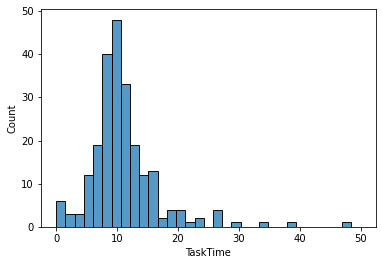

In [24]:
_ = sns.histplot(df_good.TaskTime, binrange=[0,50])

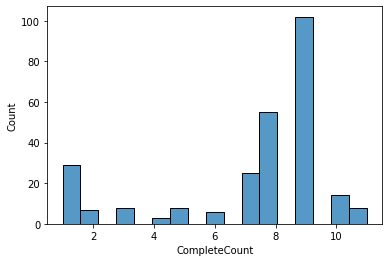

In [25]:
_ = sns.histplot(df_good.CompleteCount)

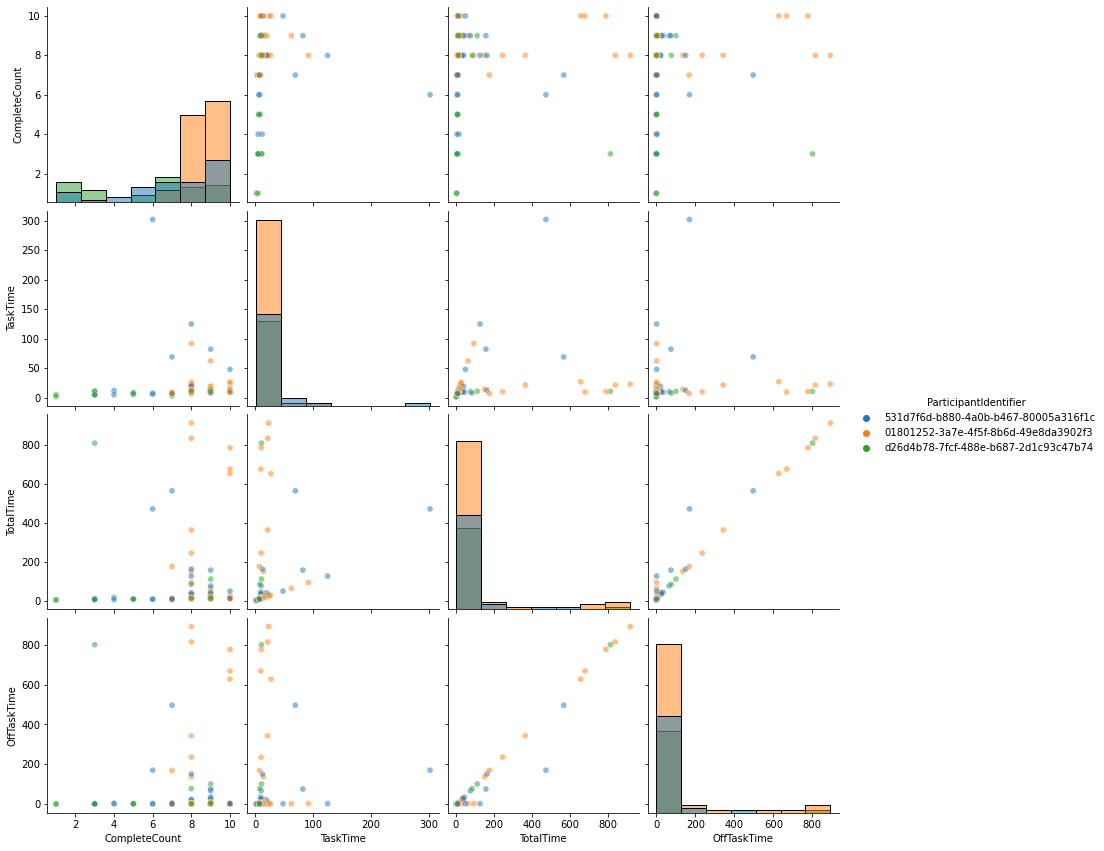

In [28]:
columns = ['CompleteCount', 'TaskTime', 'TotalTime', 'OffTaskTime']


_ = sns.pairplot(data=df_good, vars=columns,
                 hue='ParticipantIdentifier', plot_kws={'alpha': 0.5},
                 height=3, diag_kind='hist', diag_kws={'bins': 7})

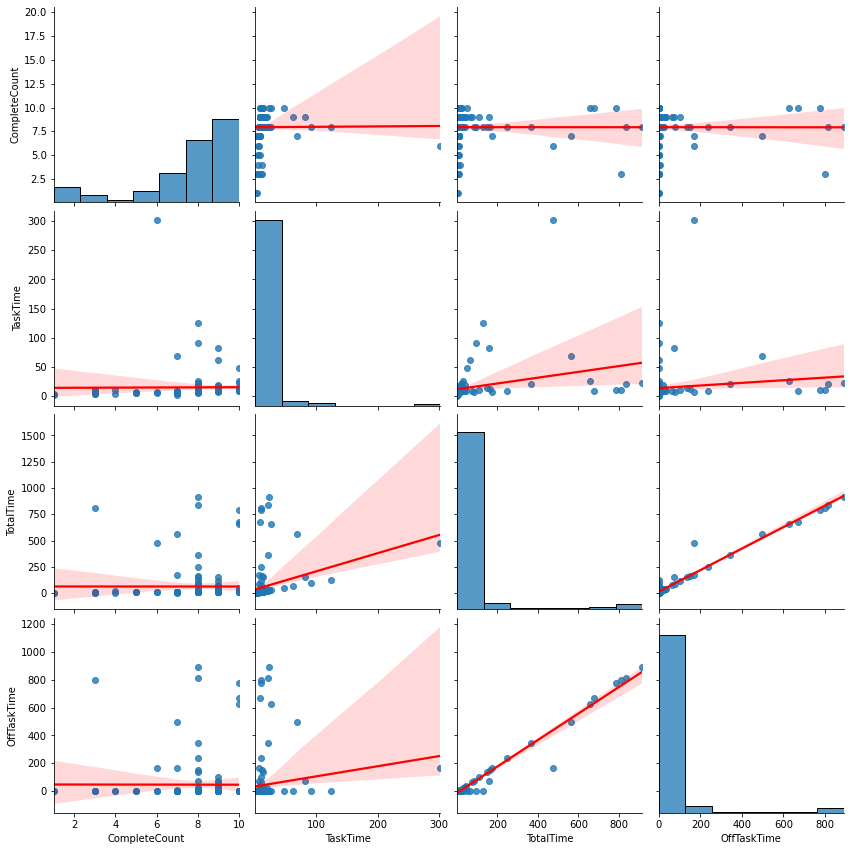

In [29]:
# look at reg line

_ = sns.pairplot(data=df_good, kind="reg",
                 vars=columns, plot_kws={'line_kws':{'color':'red'}},
                 height=3, diag_kind='hist', diag_kws={'bins': 7})

## Add Passive Features

## Add Self Report

## Add Tasks